In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
import pandas as pd
import re

from utils import *

Can we tell known from unknown whales?

I can imagine a scenario in which a CNN picks up on some specific pattern on the fluke of each of the 5004 known whales and learns to recognize them. This doesn't seem plausible though and sounds like it would be very hard to do. First of all, that is a lot of flukes (that probably don't differ that significantly from the flukes of the unknown whales, not in terms of what I would imagine a CNN can 'learn' as belonging to one class or another). Secondly, many of the pictures are taken from an angle. This is another issue that our naive approach doesn't address in any way.

I still want to attempt this. Part of the reason is certainly curiosity, though if I am to think about this competition for the next two months whatever I learn here might be useful.

In [15]:
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [16]:
(df.Id != 'new_whale').mean()

0.6189424707227633

61% of whales in the train set are known.

In [23]:
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id'); df.head()

,Image,Id,sighting_count
0,0000e88ab.jpg,w_f48451c,14.0
1,0001f9222.jpg,w_c3d896a,4.0
2,00029d126.jpg,w_20df2c5,4.0
3,00050a15a.jpg,new_whale,NaN
4,0005c1ef8.jpg,new_whale,NaN


In [64]:
df[df.Id=='w_23a388d']

,Image,Id,sighting_count
275,02bdec750.jpg,w_23a388d,73.0
297,02f250971.jpg,w_23a388d,73.0
377,03b6593e9.jpg,w_23a388d,73.0
427,043b78dc6.jpg,w_23a388d,73.0
953,09611f0c5.jpg,w_23a388d,73.0
976,0992af029.jpg,w_23a388d,73.0
1475,0ec70b0df.jpg,w_23a388d,73.0
2437,18f9ce2f9.jpg,w_23a388d,73.0
2793,1cb8f292a.jpg,w_23a388d,73.0
4157,2ac19e867.jpg,w_23a388d,73.0


In [56]:
df1 = df.groupby('Id').first()
len(df1)

5005

In [66]:
val_fns = set(df.sample(frac=1)[(df.Id != 'new_whale') & (df.sighting_count > 1)].groupby('Id').first().Image)

/home/wb/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [68]:
len(val_fns)

2931

Our validation set will consist of a single picture of whales that have at least 2 sightings.

Let's add 1000 new_whale images to the mix.

In [69]:
val_fns = val_fns.union(set(df[df.Id == 'new_whale'].sample(frac=1).Image.values[:1000]))

In [81]:
val_fns

{'b58988a20.jpg',
 '16b5433c0.jpg',
 '9f25355f2.jpg',
 '85c229533.jpg',
 '29d8a9478.jpg',
 'b88c082cc.jpg',
 '2a64fb056.jpg',
 '04622e32d.jpg',
 'a3d39166a.jpg',
 '296c15a48.jpg',
 '92489be72.jpg',
 '44d90f1e6.jpg',
 'b8ccd71ae.jpg',
 '4ad1bc58c.jpg',
 '673e12393.jpg',
 'b816dc910.jpg',
 '2d051c0f6.jpg',
 'f4e9f8d1c.jpg',
 '04515138c.jpg',
 'de7ec766b.jpg',
 '4624dc3d9.jpg',
 '387da8bd2.jpg',
 '74996cbcc.jpg',
 '88ee9bb30.jpg',
 '54a8cc32c.jpg',
 '5a2da4b18.jpg',
 '033cf66cb.jpg',
 'e9280c18c.jpg',
 '85098e666.jpg',
 '25522424a.jpg',
 '9fefaeff4.jpg',
 '8029fab03.jpg',
 '092f712cd.jpg',
 'c108bd2eb.jpg',
 'e10336883.jpg',
 '285905975.jpg',
 'abc66f880.jpg',
 '6b0180ef3.jpg',
 'b35378602.jpg',
 '7f06b6569.jpg',
 '542b11466.jpg',
 'b916f5403.jpg',
 'e6380f578.jpg',
 '13ab980b8.jpg',
 '3be9f9c21.jpg',
 '6982920d6.jpg',
 '81787a873.jpg',
 'f7d83bfa4.jpg',
 '757fbd210.jpg',
 '05e81e346.jpg',
 '5f81bd0c2.jpg',
 'bacdc3712.jpg',
 '1e78cdeb7.jpg',
 '2529525db.jpg',
 '7c402afaf.jpg',
 '513f4e7d

In [70]:
len(val_fns)

3931

In [71]:
fn2label = {row[1].Image: 'new_whale' if row[1].Id == 'new_whale' else 'known_whale' for row in df.iterrows()}

In [83]:
fn2label

{'0000e88ab.jpg': 'known_whale',
 '0001f9222.jpg': 'known_whale',
 '00029d126.jpg': 'known_whale',
 '00050a15a.jpg': 'new_whale',
 '0005c1ef8.jpg': 'new_whale',
 '0006e997e.jpg': 'new_whale',
 '000a6daec.jpg': 'known_whale',
 '000f0f2bf.jpg': 'new_whale',
 '0016b897a.jpg': 'known_whale',
 '001c1ac5f.jpg': 'known_whale',
 '001cae55b.jpg': 'known_whale',
 '001d7450c.jpg': 'new_whale',
 '00200e115.jpg': 'new_whale',
 '00245a598.jpg': 'new_whale',
 '002b4615d.jpg': 'new_whale',
 '002f99f01.jpg': 'new_whale',
 '00355ff28.jpg': 'known_whale',
 '00357e37a.jpg': 'known_whale',
 '003795857.jpg': 'new_whale',
 '0041880bf.jpg': 'new_whale',
 '0043da555.jpg': 'new_whale',
 '00442c882.jpg': 'known_whale',
 '00464ff65.jpg': 'new_whale',
 '004775679.jpg': 'known_whale',
 '004ae9e26.jpg': 'new_whale',
 '004c0f43b.jpg': 'new_whale',
 '004e8ad5b.jpg': 'known_whale',
 '004f87702.jpg': 'known_whale',
 '0050ef29d.jpg': 'known_whale',
 '00514c876.jpg': 'known_whale',
 '0052ce2f5.jpg': 'known_whale',
 '00537

In [75]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [76]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [82]:
path2fn('387da8bd2.jpg')

'387da8bd2.jpg'

In [91]:
data = (
    ImageItemList
        .from_df(df, 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [92]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (21430 items)
[Category known_whale, Category known_whale, Category known_whale, Category new_whale, Category new_whale]...
Path: data/train
x: ImageItemList (21430 items)
[Image (3, 700, 1050), Image (3, 325, 758), Image (3, 497, 1050), Image (3, 525, 1050), Image (3, 276, 980)]...
Path: data/train;

Valid: LabelList
y: CategoryList (3931 items)
[Category new_whale, Category known_whale, Category new_whale, Category known_whale, Category new_whale]...
Path: data/train
x: ImageItemList (3931 items)
[Image (3, 525, 1050), Image (3, 667, 1000), Image (3, 492, 1050), Image (3, 347, 1050), Image (3, 329, 1050)]...
Path: data/train;

Test: LabelList
y: CategoryList (7960 items)
[Category known_whale, Category known_whale, Category known_whale, Category known_whale, Category known_whale]...
Path: data/train
x: ImageItemList (7960 items)
[Image (3, 511, 767), Image (3, 640, 1050), Image (3, 644, 1050), Image (3, 600, 1050), Image (3, 525, 1050

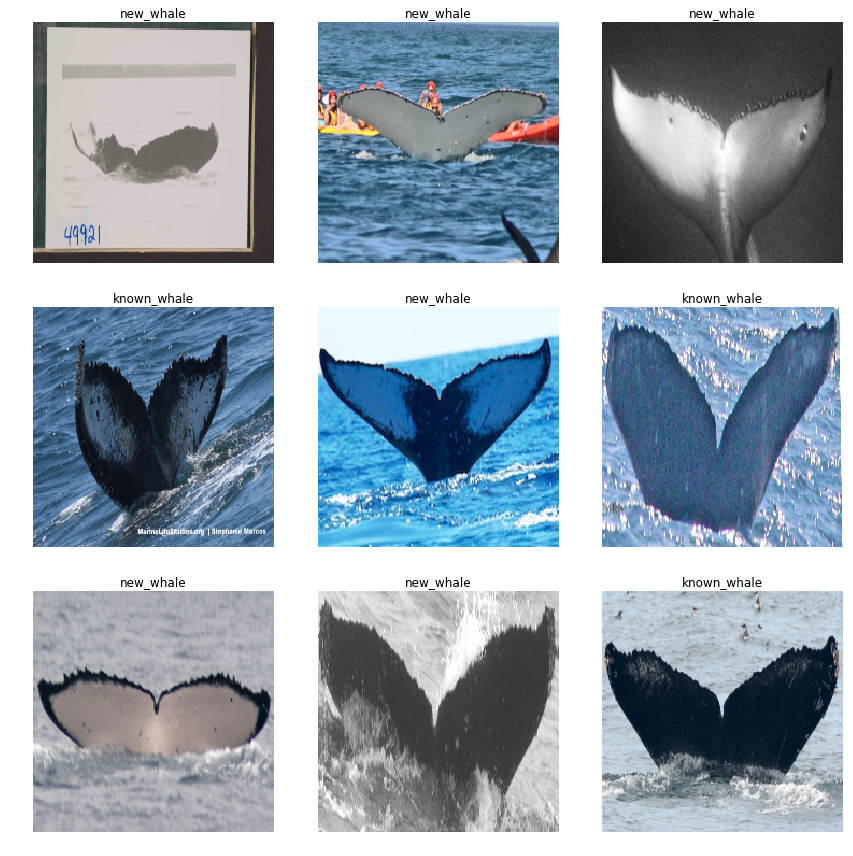

In [93]:
data.show_batch(rows=3)

## Train

In [94]:
name = f'res50-{SZ}'

In [96]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/wb/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [06:02<00:00, 282877.88it/s]


In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


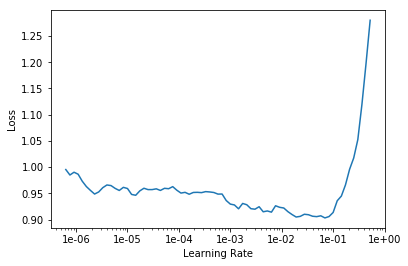

In [47]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.590176,0.585590,0.695243
2,0.552598,0.487582,0.787586
3,0.502357,0.483143,0.777156
4,0.459948,0.503538,0.767744


In [50]:
learn.save(f'{name}-stage-1')

In [56]:
learn.unfreeze()

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


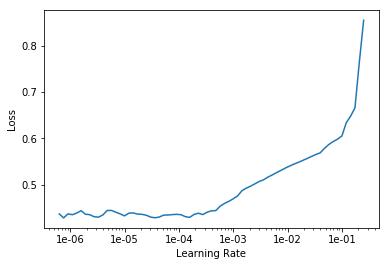

In [58]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(4, [1e-6, 1e-5, 1e-4])

epoch,train_loss,valid_loss,accuracy
1,0.452245,0.494081,0.771559
2,0.435279,0.502490,0.773086
3,0.389709,0.503176,0.776393
4,0.371523,0.500442,0.776393


In [64]:
learn.save(f'{name}-stage-2')

Accuracy of 77% sounds good, right?

In [134]:
preds, targs = learn.get_preds()

In [69]:
learn.data.classes

['known_whale', 'new_whale']

In [108]:
# https://en.wikipedia.org/wiki/Precision_and_recall
tp = ((preds.argmax(1) == 1).long() * targs).sum()
tn = ((preds.argmax(1) == 0).long() * (targs==0).long()).sum()
fn = ((preds.argmax(1) == 0).long() * targs).sum()
fp = ((preds.argmax(1) == 1).long() * (targs==0).long()).sum()

In [97]:
# recall of new_whale
tp/(tp+fn).float()

tensor(0.7250)

In [109]:
# precision
tp/(tp+fp).float()

tensor(0.5455)

In [98]:
# accuracy
(tp+tn)/(tp+tn+fp+fn).float()

tensor(0.7764)

The classifier picks up on a whale not being known 72% of the time. Out of all the whales it identifies as new, only 54% are.

Alas, this seems like a dead end. I could squeeze some LB performance out of this (when combined with another model) but definitely not worth the time at this point.